In [3]:
# System
import os
import json
from pprint import pprint
from copy import deepcopy
import socks


# Math & Visual
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import time
from plotly.offline import init_notebook_mode, plot
init_notebook_mode(connected='True')

# Geocoder
from geopy.geocoders import Baidu, Bing, GoogleV3, DataBC, Nominatim
import geopy
geopy.geocoders.options.default_timeout = 1000

# GeoVisual
from urllib.request import urlopen
import json
# with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#     counties_geo = json.load(response)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go

# bs4
from bs4 import BeautifulSoup
import requests
import multiprocessing
# from fake_useragent import UserAgent

BASE_PATH = "http://xueshu.baidu.com"
HEADERS = {
     'accept': 'image/webp,*/*;q=0.8',
    'accept-language': 'zh-CN,zh;q=0.8',
    'referer': 'http://xueshu.baidu.com/',
    'user-agent': 'Mozilla/5.0 (Windows NT 6.3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/31.0.1650.63 Safari/537.36',
    # 'User-Agent': UserAgent().random

}
BASE_PATH_GOOGLE = "https://xs.bban.top/scholar?hl=zh-CN&scisbd=1"

HEADERS_GOOGLE = {
    # "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    # "Accept-Encoding": "gzip, deflate, br",
    # "Accept-Language": "zh-CN,zh;q=0.9",
    # "Connection": "keep-alive",
    'user-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.79 Safari/537.36',
}

In [8]:
with open("./countries.geojson") as f:
    countries_geo = json.load(f)

In [9]:
# All countries
limit_countries = []
for fea in countries_geo["features"]:
    limit_countries.append(fea["properties"]['ADMIN'])

In [6]:
biorxiv_dir = './pdf_json/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

Number of articles retrieved from biorxiv: 89496


In [7]:
all_files = []
# cnt_limit = 10000
for filename in tqdm(filenames[:]):
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    file_meta = {'paper_id': file['paper_id'],
                 'metadata':file["metadata"],
#                  "abstract":file["abstract"],
                 "bib_entries":file["bib_entries"]}
    all_files.append(file_meta)

In [8]:
countries = []
no_country = []
unlocated = []
for file in tqdm(all_files):
    for i in file["metadata"]["authors"]:
        if "location" not in i["affiliation"]:
            unlocated.append({"author":i, "paper_id": file["paper_id"]})
        elif "country" not in i["affiliation"]["location"]:
#             if "settlement" in i["affiliation"]["location"]:
#                 geolocator = Nominatim(user_agent="myapp")
#                 location = geolocator.geocode(i["affiliation"]["location"]["settlement"], addressdetails=True)
#                 if location is None:
#                     geolocator = Bing('Ajg52RB8D2BIXygYwUTcJytDGsgqURLj5lfBptOH4jmTGHHFUvt0cMqdhdhdYfr-')
#                     location = geolocator.geocode(i["affiliation"]["location"]["settlement"])
#                 countries.append(location.address.split(",")[-1].strip())
#             elif "institution" in i["affiliation"]:
#                 geolocator = Nominatim(user_agent="myapp")
#                 location = geolocator.geocode(i["affiliation"]["institution"], addressdetails=True)
#                 countries.append(location.address.split(",")[-1].strip())
#             else:
#                 no_country.append(i["affiliation"])
            no_country.append({"author":i["affiliation"], "paper_id": file["paper_id"]})
        else:
            countries.append({"country":i["affiliation"]["location"]["country"], "paper_id": file["paper_id"]})

In [14]:
df_cited1000_best = pd.read_csv("./cited1000_best.csv")

In [25]:
df_cited1000_best.head()

,Unnamed: 0,paper_name,cited_cnt,year
0,3224,Clinical features of patients infected with 20...,2606,2020.0
1,760,Epidemiological and clinical characteristics o...,2180,2020.0
2,288,Clinical course and risk factors for mortality...,2058,2020.0
3,2488,A pneumonia outbreak associated with a new cor...,1799,2020.0
4,296,Clinical characteristics of coronavirus diseas...,1439,2020.0


In [15]:
# df_all_countries = pd.read_csv("./all_countries_new.csv")

In [16]:
# countries count
def countries_count(nums):
    dict={}
    for it in nums:
        it_v = it["country"]
        if it_v not in dict:
            dict[it_v] = 1
        else: dict[it_v] += 1
    return dict

dict_countries = countries_count(countries)
dict_countries["United States of America"] += dict_countries["U.S.A"] + dict_countries["USA"]
dict_countries["China"] += dict_countries["China, China"] + dict_countries["China ("] + dict_countries["China, China. •"] + dict_countries["PR China"]
df_countries_cnt = pd.DataFrame.from_dict(dict_countries, orient='index', columns=['count']).reset_index().rename(columns={"index":"country_name"}).loc[lambda x: x["country_name"].isin(limit_countries)]

In [ ]:
# df_countries = pd.read_csv('./nogeo_coutries.csv',encoding='utf-8').reset_index(drop=True)[["country", "paper_id"]]

In [17]:
df_countries_cnt.head()

,country_name,count
1,China,44934
2,Taiwan,3814
4,United States of America,43564
5,Turkey,1484
6,India,5042


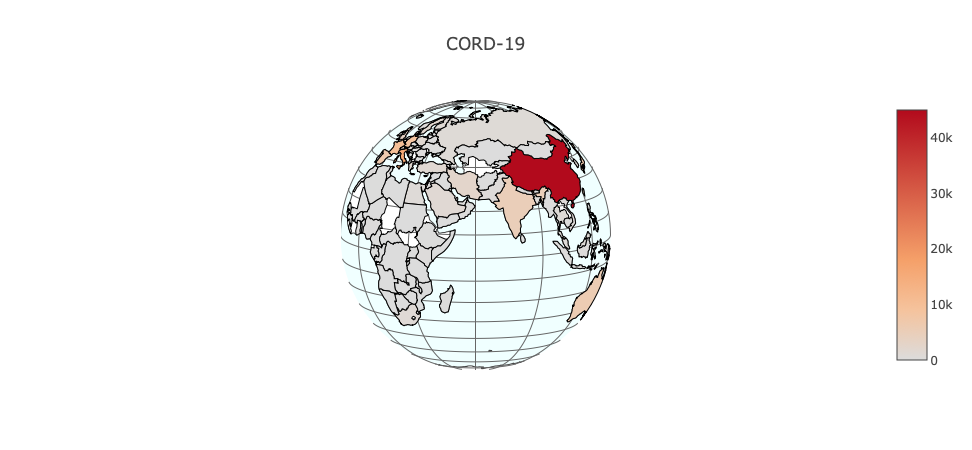

'CORD-19 worldmap.html'

In [18]:
data = [ dict(
        type = 'choropleth', # 等值线图
        locations = df_countries_cnt["country_name"],
        z = list(df_countries_cnt["count"]),
#         zauto=True,
        locationmode = 'country names',
        text = list(df_countries_cnt["count"]),
        marker = dict(line = dict(color = 'rgb(0,0,0)', width = 1)),
#         colorbar = dict(autotick = True, tickprefix = '', title = '# WTF')
            )
       ]

layout = dict(
    title = 'CORD-19',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(240,255,255)',
        projection = dict(type = 'orthographic',rotation = dict(lon = 60,lat = 10)),
        lonaxis =  dict(showgrid = True, gridcolor = 'rgb(102, 102, 102)'),
        lataxis = dict(showgrid = True,gridcolor = 'rgb(102, 102, 102)')
            )
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')
plot(data, layout, filename='CORD-19 worldmap.html')

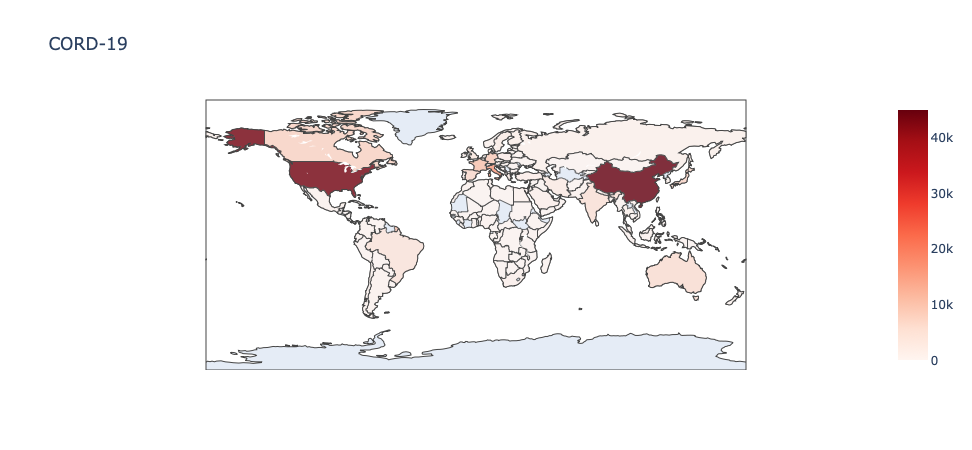

'CORD-19 countries.html'

In [19]:
fig = go.Figure(data=go.Choropleth(
    locationmode = "country names",
    locations = df_countries_cnt["country_name"],
    z = df_countries_cnt["count"],
    text = df_countries_cnt["count"],
#     autocolorscale=True,
    colorscale = 'Reds',
    zauto=True,
#     zmin=0,
#     zmax=100,
#         colorscale='viridis',
#     reversescale=False,
#     colorbar_title = 'CORD-19',
    marker_opacity=0.8,
#         marker_line_width=0.8,
        showscale=True,
))

fig.update_layout(
    title_text='CORD-19',
    geo=dict(
        showcoastlines=True,
    ),
)

fig.show()
plot(data, layout, filename='CORD-19 countries.html')

In [9]:
# Initialize the cited
cited = {}
for file in all_files:
    for bib, bib_v in file["bib_entries"].items():
        if bib_v["title"] not in cited:
            cited[bib_v["title"]] = {"cited_cnt": 1, "year": bib_v["year"]}
        else:
            cited[bib_v["title"]]["cited_cnt"] += 1

In [10]:
def year(df_i):
    if len(df_i['authors']) > 0:
        return  gscholar.query(df_i['title']+"+"+df_i['authors'][0]['last'])
    else:
        return  gscholar.query(df_i['title'])

df_0 = pd.DataFrame(all_files)
df_0['title'] = df_0['metadata'].apply(lambda x: x['title'])
df_0['year'] = df_0['metadata'].apply(lambda x: year(x))

In [11]:
df_cited = pd.DataFrame.from_dict(cited, orient='index').reset_index().rename(columns={"index":"paper_name"})

In [12]:
print("we have %.2f%% papers\' publish year in our research."%(100 * (1 - (df_cited.isna().sum()['year'] / df_cited.shape[0]))))

we have 92.71% papers' publish year in our research.


In [13]:
df_cited = df_cited.dropna()
df_cited = df_cited.sort_values(by=['cited_cnt'],axis=0, ascending=False)

In [16]:
def year_modify(df_i):
    if df_i > 2020:
        df_i -= 100
    return int(df_i)

In [17]:
df_all = pd.merge(df_0, df_cited, left_on='title', right_on='paper_name', how='right').drop('title', axis=1)
# del df_cited

In [18]:
df_all['year'] = df_all['year'].apply(lambda x: year_modify(x))

In [19]:
df_all.head()

,paper_id,metadata,bib_entries,paper_name,cited_cnt,year
0,d5fe9fda86e780265fb17373e14f86874d13865a,{'title': 'A comprehensive review and perspect...,"{'BIBREF0': {'ref_id': 'b0', 'title': 'Pharmac...",A comprehensive review and perspectives on pha...,2,2018
1,d3ac6824636f168d44e1d78f82e6c22e4d49c913,{'title': 'A comprehensive review and perspect...,"{'BIBREF0': {'ref_id': 'b0', 'title': 'Pharmac...",A comprehensive review and perspectives on pha...,2,2018
2,8a2b2c72af5a57c21d912a3f1e543bcd75345883,{'title': 'Application of next-generation sequ...,"{'BIBREF0': {'ref_id': 'b0', 'title': 'Virus d...",Application of next-generation sequencing tech...,12,2012
3,4208f9c98e378d4959debc3ba361e9cc6972e814,{'title': 'Dynamic network measures reveal the...,"{'BIBREF0': {'ref_id': 'b0', 'title': 'Estimat...",Dynamic network measures reveal the impact of ...,1,2018
4,432a9661e8c0a00f31e4e276a808a0a47860bbb5,{'title': 'The clinical impact of coronavirus ...,"{'BIBREF0': {'ref_id': 'b0', 'title': 'Human m...",The clinical impact of coronavirus infection i...,15,2015


In [81]:
df_all_year = df_all.groupby(["year"])['cited_cnt'].sum().to_frame().reset_index()

In [31]:
df_all_year.columns

Index(['year', 'cited_cnt'], dtype='object')

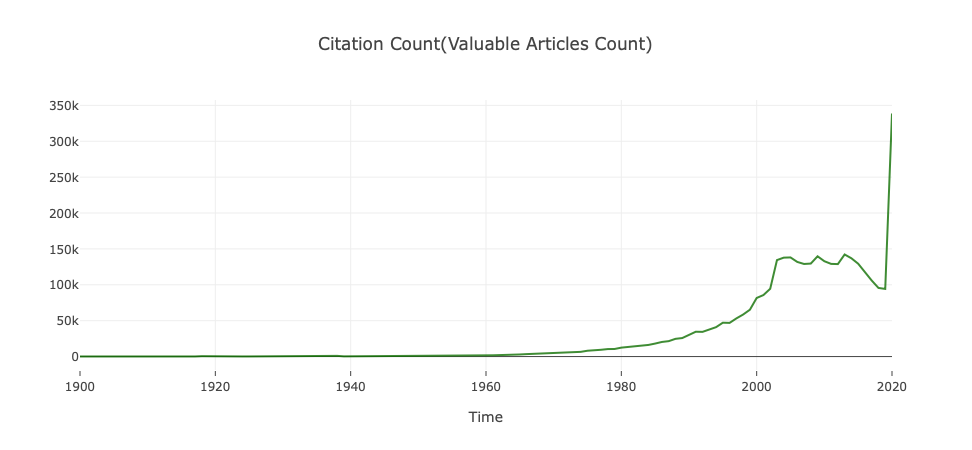

'year_cited_count.html'

In [32]:
import plotly.graph_objs as go

trace1 = go.Scatter(
                    x = df_all_year.year, 
                    y = df_all_year.cited_cnt, 
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'), 
                    text= df_all_year.cited_cnt)
                    

data = [trace1]

layout = dict(title = 'Citation Count(Valuable Articles Count)',
              xaxis= dict(title= 'Time',ticklen= 5,zeroline= False)
             ) 

fig = dict(data = data, layout = layout)
py.iplot(fig, validate=False, filename='year_cited_count')
plot(data, layout, filename='year_cited_count.html')

## NLP

### Train

In [33]:

import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), 'EFT/')).resolve().as_posix())

In [34]:
from nlp import Dataset
# del Dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
data_demo = pd.read_csv('Sentiment Analysis Dataset.csv', '\r')
# data_demo['ItemID'] = data_demo['ItemID,Sentiment,SentimentSource,SentimentText'].apply(lambda x: x.split(',')[0])
data_demo['label'] = data_demo['ItemID,Sentiment,SentimentSource,SentimentText'].apply(lambda x: x.split(',')[1])
data_demo['text'] = data_demo['ItemID,Sentiment,SentimentSource,SentimentText'].apply(lambda x: x.split(',')[3])
data_demo = data_demo.drop('ItemID,Sentiment,SentimentSource,SentimentText', axis=1)

In [36]:
data_demo['label'] = data_demo['label'].apply(lambda x: 'joy' if x is '1' else 'sad')

In [37]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [38]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(data_demo.text)

file_to_save = Path('./tokenizer.pickle').resolve()
with file_to_save.open('wb') as file:
    pickle.dump(tokenizer, file)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
data = data_demo.copy()

train = pd.DataFrame(columns=['label', 'text'])
validation = pd.DataFrame(columns=['label', 'text'])
for label in data.label.unique():
    label_data = data[data.label == label]
    train_data, validation_data = train_test_split(label_data, test_size=0.3)
    train = pd.concat([train, train_data])
    validation = pd.concat([validation, validation_data])

In [41]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [42]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = len(data.label.unique())
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [43]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

In [44]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     5000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 500)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     644096      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

In [46]:
train_sequences = [text.split() for text in train.text]
validation_sequences = [text.split() for text in validation.text]
list_tokenized_train = tokenizer.texts_to_sequences(train_sequences)
list_tokenized_validation = tokenizer.texts_to_sequences(validation_sequences)
x_train = pad_sequences(list_tokenized_train, maxlen=input_length)
x_validation = pad_sequences(list_tokenized_validation, maxlen=input_length)

encoder = LabelBinarizer()
encoder.fit(data.label.unique())

encoder_path = Path('./models/emotion_recognition', 'encoder.pickle')
with encoder_path.open('wb') as file:
    pickle.dump(encoder, file)

y_train = encoder.transform(train.label)
y_validation = encoder.transform(validation.label)

In [47]:
batch_size = 128
epochs = 1

In [48]:
model.fit(
    x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_validation, y_validation)
)

Train on 1105038 samples, validate on 473589 samples
1105038/1105038 [==============================] - 7054s 6ms/sample - loss: 0.4944 - accuracy: 0.7558 - val_loss: 0.4776 - val_accuracy: 0.7672


In [49]:
model_file = Path('./models/emotion_recognition/model_weights.h5').resolve()
model.save_weights(model_file.as_posix())

### Inference

In [2]:
import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), 'EFT/')).resolve().as_posix())
import pickle
tokenizer_path = Path('./tokenizer.pickle').resolve()
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = 2
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)
model_weights_path = Path('./models/emotion_recognition/model_weights.h5').resolve()
model.load_weights(model_weights_path.as_posix())

In [3]:
encoder_path = Path('./models/emotion_recognition/encoder.pickle').resolve()
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

In [4]:
from nlp import preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# all
sequences = [text.split() for text in df_all.apply(lambda x: x["paper_name"]+":"+x["abstract"])]
list_tokenized = tokenizer.texts_to_sequences(sequences)
x_data = pad_sequences(list_tokenized, maxlen=100)

In [ ]:
# demo
head_num = 10000
sequences_demo = [text.split() for text in df_all.apply(lambda x: x["paper_name"]+":"+x["abstract"]).head(head_num)]
list_tokenized_demo = tokenizer.texts_to_sequences(sequences_demo)
x_data_demo = pad_sequences(list_tokenized_demo, maxlen=100)

In [ ]:
y_pred = model.predict(x_data)

In [54]:
y_pred = model.predict(x_data[:1000])
for i in tqdm(range(1000, len(x_data), 1000)):
#     print(i)
    if i + 1000 < len(x_data):
        y_pred = np.append(y_pred, model.predict(x_data[i:i+1000]))

In [62]:
end_num = df_all.shape[0] % 1000
end_num

336

In [63]:
for i in tqdm(range(1000, len(x_data), 1000)):
#     print(i)
    if i + 1000 > len(x_data):
        y_pred = np.append(y_pred, model.predict(x_data[i:]))

In [68]:
y_pred = y_pred.reshape(-1, 2)

In [70]:
np.savetxt('new.csv', y_pred, delimiter = ',')

In [71]:
df_pred = pd.DataFrame(y_pred, columns=['sad', 'joy'])
df_pred['result'] = df_pred.apply(lambda x: -1 if x['sad'] > x['joy'] else 1, axis=1)

In [72]:
df_pred = df_pred.drop(['sad', 'joy'], axis=1)

In [73]:
df_pred

,result
0,-1
1,-1
2,1
3,-1
4,1
...,...
2016331,1
2016332,1
2016333,-1
2016334,1


In [18]:
df_pred.to_csv("df_pred.csv",sep=',')

In [31]:
df_pred = pd.read_csv("df_pred.csv", header=0, names=['id', 'result']).set_index(['id'])

In [33]:
df_pred

,result
id,
0,-1
1,-1
2,1
3,-1
4,1
...,...
2016331,1
2016332,1
2016333,-1


In [40]:
df_pred.loc[df_pred['result']==1].shape[0]

753143

In [41]:
df_pred.loc[df_pred['result']==-1].shape[0]

1263193

In [75]:
del df_0, df_cited, all_files

In [76]:
df_all_head = df_all[["paper_name",'year','cited_cnt']]
df_all_head = pd.merge(df_all_head, df_pred, left_index=True, right_index=True, how='inner')
df_all_head['new_result'] = df_all_head.apply(lambda x: x['cited_cnt'] * x['result'], axis=1)
df_all_head.groupby("year")["result"].sum()

year
1900      -71
1901      -44
1902      -31
1903      -46
1904      -43
        ...  
2016   -18289
2017   -19900
2018   -19990
2019   -19576
2020   -25764
Name: result, Length: 121, dtype: int64

In [85]:
df_all_head

,paper_name,year,cited_cnt,result,new_result
0,A comprehensive review and perspectives on pha...,2018,2,-1,-2
1,A comprehensive review and perspectives on pha...,2018,2,-1,-2
2,Application of next-generation sequencing tech...,2012,12,1,12
3,Dynamic network measures reveal the impact of ...,2018,1,-1,-1
4,The clinical impact of coronavirus infection i...,2015,15,1,15
...,...,...,...,...,...
2016331,Age-related changes in T cell mediated immune ...,2010,1,1,1
2016332,Respiratory syncytial virus infection in adult...,2007,1,1,1
2016333,Influenzaand RSV-associated hospitalizations a...,2007,1,-1,-1
2016334,Respiratory syncytial virus (RSV) and persiste...,2001,1,1,1


In [91]:
df_emotion_change#_new

year
1900    1.316355e+06
1901    8.157691e+05
1902    5.747464e+05
1903    8.528495e+05
1904    7.972289e+05
            ...     
2016    3.390818e+08
2017    3.689501e+08
2018    3.706187e+08
2019    3.629431e+08
2020    4.776699e+08
Name: result, Length: 121, dtype: float64

In [107]:
df_emotion_change_new = df_all_head.groupby("year")["new_result"].sum()#*np.random.normal(0, df_all_head.groupby("year")["result"].count().mean(), 1)

In [108]:
df_emotion_change = df_all_head.groupby("year")["result"].sum()#*np.random.normal(0, df_all_head.groupby("year")["result"].count().mean(), 1)

In [109]:
k_start = 0
#.iloc[0] = -167
for i in range(df_emotion_change.shape[0]):
    k_start += df_emotion_change.iloc[i]
    df_emotion_change.iloc[i] = k_start

In [110]:
k_start = 0
#.iloc[0] = -167
for i in range(df_emotion_change_new.shape[0]):
    k_start += df_emotion_change_new.iloc[i]
    df_emotion_change_new.iloc[i] = k_start

In [117]:
df_emotion = df_emotion_change.to_frame().reset_index()#.year
df_emotion_new = df_emotion_change_new.to_frame().reset_index()#.year

In [112]:
df_emotion

,year,result
0,1900,-71
1,1901,-115
2,1902,-146
3,1903,-192
4,1904,-235
...,...,...
116,2016,-424820
117,2017,-444720
118,2018,-464710
119,2019,-484286


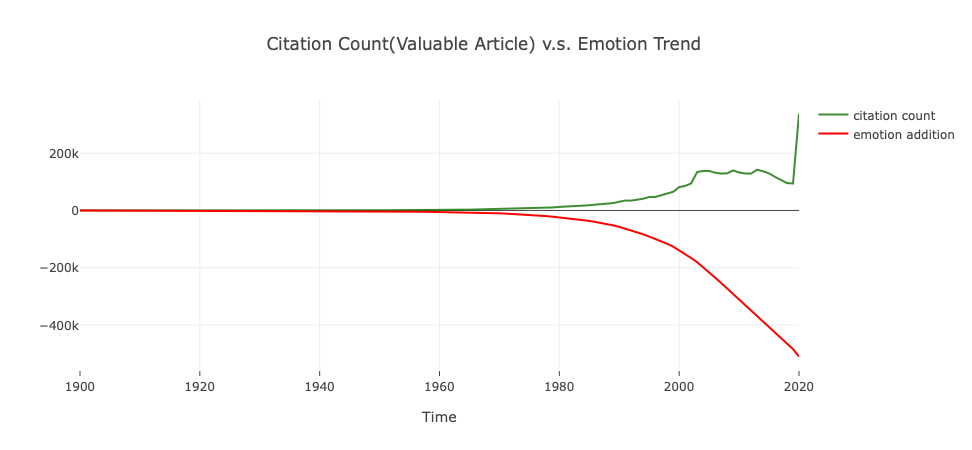

'year_all.html'

In [119]:
import plotly.graph_objs as go

trace1 = go.Scatter(
                    x = df_all_year.year,
                    y = df_all_year.cited_cnt,
                    mode = "lines", 
                    name = "citation count",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'), 
                    text= df_all_year.cited_cnt)


trace2 = go.Scatter(
                    x = df_emotion.year,
                    y = df_emotion.result,
                    mode = "lines",
                    name = "emotion addition",
                    marker = dict(color = 'red'), 
                    text= df_emotion.result)
data = [trace1, trace2]

layout = dict(title = 'Citation Count(Valuable Article) v.s. Emotion Trend',
              xaxis= dict(title= 'Time',ticklen= 5,zeroline= False)
             ) 

fig = dict(data = data, layout = layout)
py.iplot(fig, validate=False, filename='year_cited_count')
plot(data, layout, filename='year_all.html')

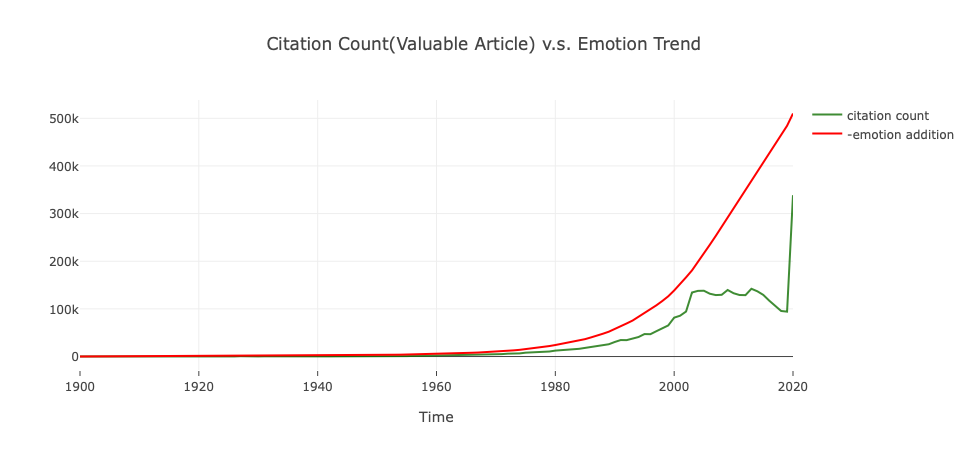

'year_all_-emo.html'

In [120]:
import plotly.graph_objs as go

trace1 = go.Scatter(
                    x = df_all_year.year,
                    y = df_all_year.cited_cnt,
                    mode = "lines", 
                    name = "citation count",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'), 
                    text= df_all_year.cited_cnt)


trace2 = go.Scatter(
                    x = df_emotion.year,
                    y = -df_emotion.result,
                    mode = "lines",
                    name = "-emotion addition",
                    marker = dict(color = 'red'), 
                    text= df_emotion.result)
data = [trace1, trace2]

layout = dict(title = 'Citation Count(Valuable Article) v.s. Emotion Trend',
              xaxis= dict(title= 'Time',ticklen= 5,zeroline= False)
             ) 

fig = dict(data = data, layout = layout)
py.iplot(fig, validate=False, filename='year_cited_count')
plot(data, layout, filename='year_all_-emo.html')

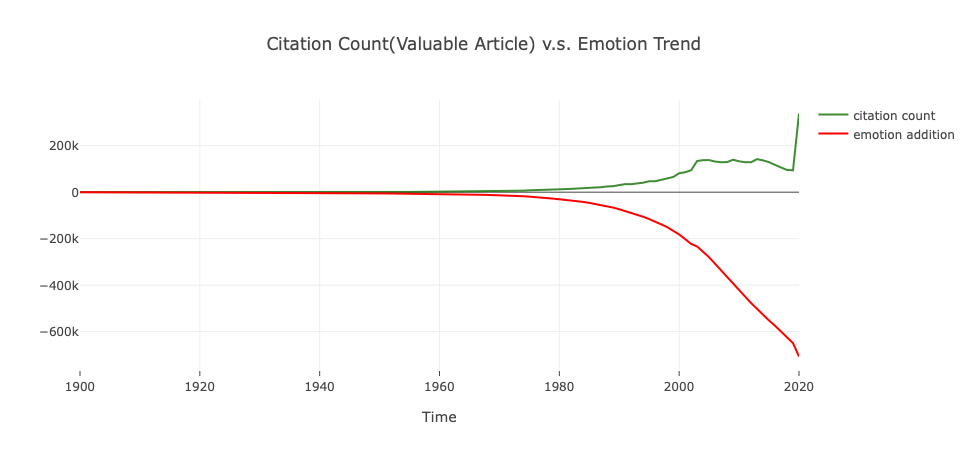

'year_all_re.html'

In [121]:

import plotly.graph_objs as go

trace1 = go.Scatter(
                    x = df_all_year.year,
                    y = df_all_year.cited_cnt,
                    mode = "lines",
                    name = "citation count",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'), 
                    text= df_all_year.cited_cnt)


trace2 = go.Scatter(
                    x = df_emotion_new.year,
                    y = df_emotion_new.new_result,
                    mode = "lines",
                    name = "emotion addition",
                    marker = dict(color = 'red'), 
                    text= df_emotion_new.new_result)
data = [trace1, trace2]

layout = dict(title = 'Citation Count(Valuable Article) v.s. Emotion Trend',
              xaxis= dict(title= 'Time',ticklen= 5,zeroline= False)
              ) 

fig = dict(data = data, layout = layout)
py.iplot(fig, validate=False, filename='year_cited_count')
plot(data, layout, filename='year_all_re.html')

###### demo part

In [ ]:
df_all_head10000 = df_all[["paper_name",'year','cited_cnt']].head(head_num)
# df_all_head10000['label'] = y_pred

In [ ]:
df_all_head10000 = pd.merge(df_all_head10000, df_pred_10000, left_index=True, right_index=True, how='inner')

In [ ]:
df_all_head10000['new_result'] = df_all_head10000.apply(lambda x: x['cited_cnt'] * x['result'], axis=1)

In [ ]:
df_all_head10000

In [ ]:
df_all_head10000.groupby("year")["result"].sum()

In [ ]:
df_all

In [ ]:
df_all_head10000

In [ ]:
df_emotion_change = df_all_head10000.groupby("year")["new_result"].sum()*np.random.normal(0, df_all_head10000.groupby("year")["result"].count().mean(), 1)

In [ ]:
k_start = 0
#.iloc[0] = -167
for i in range(df_emotion_change.shape[0]):
    k_start += df_emotion_change.iloc[i]
    df_emotion_change.iloc[i] = k_start

In [ ]:
df_emotion = df_emotion_change.to_frame().reset_index()#.year

In [ ]:
df_emotion

In [ ]:
import plotly.graph_objs as go

trace1 = go.Scatter(
                    x = df_all_year.year,
                    y = df_all_year.cited_cnt,
                    mode = "lines", 
                    name = "citation count",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'), 
                    text= df_all_year.cited_cnt)


trace2 = go.Scatter(
                    x = df_emotion.year,
                    y = -df_emotion.result,
                    mode = "lines",
                    name = "-emotion addition",
                    marker = dict(color = 'red'), 
                    text= df_emotion.result)
data = [trace1, trace2]

layout = dict(title = 'Citation Count(Valuable Article) v.s. Emotion Trend',
              xaxis= dict(title= 'Time',ticklen= 5,zeroline= False)
             ) 

fig = dict(data = data, layout = layout)
py.iplot(fig, validate=False, filename='year_cited_count')
plot(data, layout, filename='year_all.html')

In [ ]:

import plotly.graph_objs as go

trace1 = go.Scatter(
                    x = df_all_year.year,
                    y = df_all_year.cited_cnt,
                    mode = "lines",
                    name = "citation count",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'), 
                    text= df_all_year.cited_cnt)


trace2 = go.Scatter(
                    x = df_emotion.year,
                    y = df_emotion.new_result,
                    mode = "lines",
                    name = "emotion addition",
                    marker = dict(color = 'red'), 
                    text= df_emotion.new_result)
data = [trace1, trace2]

layout = dict(title = 'Citation Count(Valuable Article) v.s. Emotion Trend',
              xaxis= dict(title= 'Time',ticklen= 5,zeroline= False)
              ) 

fig = dict(data = data, layout = layout)
py.iplot(fig, validate=False, filename='year_cited_count')
plot(data, layout, filename='year_all.html')

In [ ]:
df_cited1000_best

In [ ]:
df = px.data.tips()
# Here we use a column with categorical data
fig = px.histogram(df_cited1000_best, x="paper_name", y='cited_cnt')
fig.show()
plot(data, layout, filename='cited_1000best.html')